In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from xgboost import XGBRegressor
import re


In [ ]:
lab_df = pd.read_csv('/content/real_data_ferm.csv')
syn_df = pd.read_csv('/content/ferm_table_of_data(500 total results).csv', sep=';', encoding='latin1')
lab_df = lab_df.drop(columns=['Unnamed: 0'])
lab_df = lab_df.dropna(subset=['Fruit'])
lab_df = lab_df.drop(columns=['Strains','Other changes'])
syn_df = syn_df.drop(columns=['Alkalizing Agent'])
syn_df = syn_df.dropna(axis=1, how='all')  # Removes fully empty columns
syn_df = syn_df.drop(columns=['Unnamed: 15'])
lab_df.head(5)

,Fruit,Time,Temp [*C],pH (before ferm.),Sugar,pH (post fermrntation)
0,Blueberry,28h,37,6.2 Na2CO3,Glucose 1.5%,3.08
3,Blueberry,48h,NaN,4 Na2CO3,"Glucose, Brix 13",<3.6
4,Blueberry,96h (after 72h no sign changes),37,5.5 Na2CO3,not added,3.09
5,Lingonberry (pohl),21 d (until TSS ~5 Brix),22 to 25,NaN,after benzoic acid removal sucrose added for ...,NaN
6,Lingonberry (pohl),7d,25,5.2 NaOH,Around 15 brix throughout the fermentation,4.6-4.8


In [ ]:
syn_df.head(5)

,Fruit,Time,Temp [°C],pH (before fermentation),Sugar (before fermentation),pH (post fermentation),aeration,difference
0,Cranberry,28h,32,"5,1",Glucose 1.5%,"3,5","0,77","1,6"
1,Blueberry,21d,35,"6,4",Glucose 2%,"3,3","0,11","3,1"
2,Lingonberry,28h,34,"6,4",Glucose 1.5%,"3,8","0,12","2,6"
3,Blueberry,48h,38,5,Glucose 1.5%,"3,3","2,42","1,7"
4,Blackcurrant,36h,39,"6,1",Glucose 2%,"4,4","3,18","1,7"


In [ ]:
lab_df[['Time','Temp [*C]','pH (before ferm.)','pH (post fermrntation)','Sugar']].value_counts()

,,,,,count
Time,Temp [*C],pH (before ferm.),pH (post fermrntation),Sugar,
28h,37,6.2 Na2CO3,3.08,Glucose 1.5%,1
48 h,37°C,Adjusted to 4.2,non-specify,Added Sucrose10% (mass concentration),1
72 h,37,2.9 (not adhjusted),3.03,for 500 g berries 50 g sugar added,1
7d,25,5.2 NaOH,4.6-4.8,Around 15 brix throughout the fermentation,1
96h (after 72h no sign changes),37,5.5 Na2CO3,3.09,not added,1
stopped when Brix was constant for 24 h,21,2.96 not adjusted,2.93-3.07,not added. 77.5 g/l,1


In [ ]:
# Rename columns in syn_df to match lab_df
syn_df = syn_df.rename(columns={
    'Time': 'Time',
    'Temp [°C]': 'Temp [*C]',
    'pH (before fermentation)': 'pH (before ferm.)',
    'pH (post fermentation)': 'pH (post fermrntation)',
    'Sugar (before fermentation)': 'Sugar'
})

# Display value counts
syn_df[['Time', 'Temp [*C]', 'pH (before ferm.)', 'pH (post fermrntation)', 'Sugar']].value_counts()


Time  Temp [*C]  pH (before ferm.)  pH (post fermrntation)  Sugar                                   
96h   40         6,2                4,3                     Sucrose 10 Brix                             1
14d   22         6,3                3                       Around 15 Brix                              1
96h   36         5,8                3,1                     Sucrose added after benzoic acid removal    1
      35         5,5                3                       Sucrose added after benzoic acid removal    1
      34         6,1                4,2                     Sucrose added after benzoic acid removal    1
                                                                                                       ..
14d   25         5,9                4,7                     Glucose 1.5%                                1
                 5,5                4,7                     Sucrose added after benzoic acid removal    1
      23         6                  3,2                     Sucrose added after benzoic acid removal    1
                 5,7                4                       Sucrose 10 Brix                             1
                 5,5                4,5                     Sucrose added after benzoic acid removal    1
Name: count, Length: 482, dtype: int64

In [ ]:
lab_df['Sugar'].unique()

array(['Glucose 1.5%', 'Glucose, Brix 13', 'not added',
       'after benzoic acid removal sucrose added for  14 brix',
       'Around 15 brix throughout the fermentation',
       'not added. 77.5 g/l', 'sugar added', nan, '3% (w/v) sugars',
       'for 500 g berries 50 g sugar added',
       'Added Sucrose10% (mass concentration)'], dtype=object)

In [ ]:
syn_df['Sugar'].unique()

array(['Glucose 1.5%', 'Glucose 2%',
       'Sucrose added after benzoic acid removal', 'Fructose 8%',
       'Sucrose 10 Brix', 'Not added', 'Around 15 Brix'], dtype=object)

In [ ]:
# Function to standardize sugar concentration
def standardize_sugar(value, median_value):
    if isinstance(value, str):
        value = value.lower()  # Normalize case

        # Case: No sugar added
        if "not added" in value:
            return 0  # No sugar added

        # Case: "Sugar added" (impute with median)
        if "sugar added" in value or "sucrose added" in value:
            return median_value if median_value is not None else np.nan

        # Case: Extract Brix values (both "13 Brix" and "Brix 13")
        brix_match = re.search(r'(?:brix\s*(\d+(\.\d+)?)|(\d+(\.\d+)?)\s*brix)', value)
        if brix_match:
            brix_val = brix_match.group(1) or brix_match.group(3)
            return float(brix_val) * 10  # Convert Brix to g/L

        # Case: Extract percentage values
        percent_match = re.search(r'(\d+(\.\d+)?)\s*%', value)
        if percent_match:
            return float(percent_match.group(1)) * 10  # Convert % to g/L

        # Case: Extract g/L values
        g_per_l_match = re.search(r'(\d+(\.\d+)?)\s*g/?l', value)
        if g_per_l_match:
            return float(g_per_l_match.group(1))

        # Case: "500 g berries 50 g sugar added" → g/L
        berries_match = re.search(r'(\d+)\s*g berries.*?(\d+)\s*g sugar added', value)
        if berries_match:
            berries_weight = float(berries_match.group(1))
            sugar_weight = float(berries_match.group(2))
            return (sugar_weight / berries_weight) * 1000  # Convert to g/L

    return np.nan  # Return NaN for unrecognized cases

# Compute the median from available "Sugar g/L" values
median_sugar = pd.concat([lab_df['Sugar'], syn_df['Sugar']]).apply(
    lambda x: standardize_sugar(x, np.nan)
).median()

# Apply the function
lab_df['Sugar g/L'] = lab_df['Sugar'].apply(lambda x: standardize_sugar(x, median_sugar))
syn_df['Sugar g/L'] = syn_df['Sugar'].apply(lambda x: standardize_sugar(x, median_sugar))

# Display results
print(lab_df[['Sugar', 'Sugar g/L']])
print(syn_df[['Sugar', 'Sugar g/L']])


                                                Sugar  Sugar g/L
0                                        Glucose 1.5%       15.0
3                                    Glucose, Brix 13      130.0
4                                           not added        0.0
5   after benzoic acid removal sucrose added for  ...       80.0
6          Around 15 brix throughout the fermentation      150.0
9                                 not added. 77.5 g/l        0.0
10                                        sugar added       80.0
11                                                NaN        NaN
12                                    3% (w/v) sugars       30.0
14                                                NaN        NaN
15                 for 500 g berries 50 g sugar added       80.0
16              Added Sucrose10% (mass concentration)      100.0
17                                                NaN        NaN
18                                                NaN        NaN
19                       

In [ ]:
lab_df['Sugar g/L'] = lab_df['Sugar g/L'].fillna(lab_df['Sugar g/L'].median())
lab_df['Sugar g/L'].isna().sum()

np.int64(0)

In [ ]:
syn_df['Sugar g/L'].isna().sum()

np.int64(0)

In [ ]:
lab_df['Time'].unique()

array(['28h', '48h', '96h (after 72h no sign changes)',
       '21 d (until TSS ~5 Brix)', '7d',
       'stopped when Brix was constant for 24 h', '3-4 d', '6 d',
       '20 h (they tested different ferm times, after 20h TFC decreased)',
       '72 h', '48 h', '24 h'], dtype=object)

In [ ]:
syn_df['Time'].unique()

array(['28h', '21d', '48h', '36h', '72h', '24h', '14d', '96h', '7d'],
      dtype=object)

In [ ]:
lab_df['Temp [*C]'].unique()

array(['37', nan, '22 to 25', '25', '21', '37°C'], dtype=object)

In [ ]:
syn_df['Temp [*C]'].unique()

array([32, 35, 34, 38, 39, 31, 28, 29, 26, 23, 36, 37, 40, 33, 24, 22, 27,
       30, 25])

In [ ]:
syn_df.isna().sum()

,0
Fruit,0
Time,0
Temp [*C],0
pH (before ferm.),0
Sugar,0
pH (post fermrntation),0
aeration,0
difference,0
Sugar g/L,0


In [ ]:
lab_df.isna().sum()

,0
Fruit,0
Time,0
Temp [*C],10
pH (before ferm.),4
Sugar,8
pH (post fermrntation),4
Sugar g/L,0


In [ ]:
syn_df['pH (post fermrntation)'].value_counts()

,count
pH (post fermrntation),
"4,1",36
"3,4",34
"3,3",32
"3,5",28
"3,2",28
"3,7",26
4,26
"3,6",25
"4,5",24


In [ ]:
# Function to convert time to hours
def convert_time_to_hours(time_str):
    if isinstance(time_str, int):  # If the value is already an integer
        return time_str

    match = re.search(r'(\d+)', str(time_str))  # Find the first number

    if match:
        num = int(match.group(1))
        if 'h' in time_str:
            return num  # Keep as hours
        elif 'd' in time_str:
            return num * 24  # Convert days to hours
    return None  # Return None if no valid time format found

def clean_temperature(temp):
    if pd.isna(temp):  # Handle NaN values
        return None
    temp = str(temp).strip()  # Convert to string and remove spaces
    temp = temp.replace("°C", "")  # Remove "°C" if present

    if " to " in temp:  # Handle ranges like "22 to 25"
        low, high = map(float, temp.split(" to "))
        return (low + high) / 2  # Return the average of the range

    return pd.to_numeric(temp, errors='coerce')  # Convert to number, return NaN for invalid inputs

# Function to extract numeric pH value
def extract_pH(value):
    if pd.isna(value):
        return None  # Handle NaN values
    match = re.search(r"\d+(\.\d+)?", str(value))  # Find first number
    return float(match.group()) if match else None

def clean_pH(value):
    if isinstance(value, str):
        if "<" in value:
            return 3.5  # Assign 3.5 for "<x" cases
        elif "-" in value:
            # Extract two numbers and take their average
            numbers = [float(num.replace(',', '.')) for num in re.findall(r"\d+\.\d+", value)]
            return sum(numbers) / len(numbers) if numbers else None
        else:
            try:
                return float(value.replace(',', '.'))  # Convert normal pH values (handle comma as decimal)
            except ValueError:
                return None  # Handle unexpected values
    return value  # Return as is if already a number

# Apply the function
lab_df['Temp C'] = lab_df['Temp [*C]'].apply(clean_temperature)
lab_df['Time hours'] = lab_df['Time'].apply(convert_time_to_hours)
lab_df['Numerical pH before ferm'] = lab_df['pH (before ferm.)'].apply(extract_pH)
lab_df['Numerical pH post ferm'] = lab_df['pH (post fermrntation)'].apply(clean_pH)
# Drop the original Time column if needed
lab_df = lab_df.drop(columns=['Time','Temp [*C]','pH (before ferm.)','pH (post fermrntation)','Sugar'])
#print(lab_df)

# Apply the function to 'new_syn_df'
syn_df['Temp C'] = syn_df['Temp [*C]'].apply(clean_temperature)
syn_df['Time hours'] = syn_df['Time'].apply(convert_time_to_hours)
syn_df['Numerical pH before ferm'] = syn_df['pH (before ferm.)'].apply(extract_pH)
syn_df['Numerical pH post ferm'] = syn_df['pH (post fermrntation)'].apply(clean_pH)

# Drop the original columns
syn_df = syn_df.drop(columns=['Time', 'Temp [*C]', 'pH (before ferm.)', 'pH (post fermrntation)', 'Sugar'])


In [ ]:
lab_df.columns

Index(['Fruit', 'Sugar g/L', 'Temp C', 'Time hours',
       'Numerical pH before ferm', 'Numerical pH post ferm'],
      dtype='object')

In [ ]:
syn_df.columns

Index(['Fruit', 'aeration', 'difference', 'Sugar g/L', 'Temp C', 'Time hours',
       'Numerical pH before ferm', 'Numerical pH post ferm'],
      dtype='object')

In [ ]:
syn_df.isna().sum()

,0
Fruit,0
aeration,0
difference,0
Sugar g/L,0
Temp C,0
Time hours,0
Numerical pH before ferm,0
Numerical pH post ferm,0


In [ ]:
lab_df.isna().sum()

,0
Fruit,0
Sugar g/L,0
Temp C,10
Time hours,0
Numerical pH before ferm,4
Numerical pH post ferm,5


In [ ]:
# Remove specific fruits
lab_df = lab_df[~lab_df['Fruit'].isin(['Chinese bayberry\xa0', 'Sea buckthorn', 'Orange'])]

# Rename "Lingonberry (pohl)" to "Lingonberry"
lab_df['Fruit'] = lab_df['Fruit'].replace({'Lingonberry (pohl)': 'Lingonberry'})

# Display the updated DataFrame
print(lab_df['Fruit'].value_counts())


Fruit
Blueberry        3
Black currant    3
Lingonberry      2
Name: count, dtype: int64


In [ ]:
syn_df['Fruit'].value_counts()

,count
Fruit,
Lingonberry,124
Blueberry,123
Blackcurrant,120
Cranberry,115


In [ ]:
# Standardize fruit names before mapping
lab_df['Fruit'] = lab_df['Fruit'].str.strip().replace({'Black currant': 'Blackcurrant'})# Define a dictionary to map fruit names to numeric values
fruit_mapping = {
    "Blueberry": 1,
    "Blackcurrant": 2,
    "Lingonberry": 3,
    "Cranberry": 4
}


# Apply the mapping to the 'Fruit' column in both DataFrames
syn_df['Fruit Numeric'] = syn_df['Fruit'].map(fruit_mapping)
lab_df['Fruit Numeric'] = lab_df['Fruit'].map(fruit_mapping)

# Check the result
print(syn_df[['Fruit', 'Fruit Numeric']].head())
print(lab_df[['Fruit', 'Fruit Numeric']].head())


          Fruit  Fruit Numeric
0     Cranberry              4
1     Blueberry              1
2   Lingonberry              3
3     Blueberry              1
4  Blackcurrant              2
         Fruit  Fruit Numeric
0    Blueberry              1
3    Blueberry              1
4    Blueberry              1
5  Lingonberry              3
6  Lingonberry              3


In [ ]:
lab_df.isna().sum()

,0
Fruit,0
Sugar g/L,0
Temp C,3
Time hours,0
Numerical pH before ferm,2
Numerical pH post ferm,2
Fruit Numeric,0


In [ ]:
syn_df['aeration'].value_counts()

,count
aeration,
"0,98",5
"1,51",5
"0,54",4
"0,68",4
"2,86",4
...,...
"2,76",1
"2,35",1
"3,26",1


In [ ]:
# Fill NaN values with the median for each column without using inplace=True
lab_df['Temp C'] = lab_df['Temp C'].fillna(lab_df['Temp C'].median())
lab_df['Numerical pH before ferm'] = lab_df['Numerical pH before ferm'].fillna(lab_df['Numerical pH before ferm'].median())
lab_df['Numerical pH post ferm'] = lab_df['Numerical pH post ferm'].fillna(lab_df['Numerical pH post ferm'].median())
lab_df.drop(columns=['Fruit'], inplace=True)
syn_df.drop(columns=['Fruit'], inplace=True)
# Verify if there are any remaining NaN values
print(lab_df[['Temp C', 'Numerical pH before ferm', 'Numerical pH post ferm']].isna().sum())


Temp C                      0
Numerical pH before ferm    0
Numerical pH post ferm      0
dtype: int64


In [ ]:
lab_df.head(5)

,Sugar g/L,Temp C,Time hours,Numerical pH before ferm,Numerical pH post ferm,Fruit Numeric
0,15.0,37.0,28,6.2,3.080,1
3,130.0,25.0,48,4.0,3.500,1
4,0.0,37.0,96,5.5,3.090,1
5,80.0,23.5,504,4.8,3.085,3
6,150.0,25.0,168,5.2,4.700,3


In [ ]:
syn_df.head(5)

,aeration,difference,Sugar g/L,Temp C,Time hours,Numerical pH before ferm,Numerical pH post ferm,Fruit Numeric
0,"0,77","1,6",15.0,32,28,5.0,3.5,4
1,"0,11","3,1",20.0,35,504,6.0,3.3,1
2,"0,12","2,6",15.0,34,28,6.0,3.8,3
3,"2,42","1,7",15.0,38,48,5.0,3.3,1
4,"3,18","1,7",20.0,39,36,6.0,4.4,2


In [ ]:
len(lab_df), len(syn_df)

(8, 482)

In [ ]:
# Convert numeric columns with commas to proper float format
syn_df['aeration'] = syn_df['aeration'].astype(str).str.replace(',', '.').astype(float)
syn_df['difference'] = syn_df['difference'].astype(str).str.replace(',', '.').astype(float)

lab_df['aeration'] = syn_df['aeration'].mean()

# Check if there are still missing values
lab_df['aeration'].isna().sum()

np.int64(0)

In [ ]:
syn_df.head()

,aeration,difference,Sugar g/L,Temp C,Time hours,Numerical pH before ferm,Numerical pH post ferm,Fruit Numeric
0,0.77,1.6,15.0,32,28,5.0,3.5,4
1,0.11,3.1,20.0,35,504,6.0,3.3,1
2,0.12,2.6,15.0,34,28,6.0,3.8,3
3,2.42,1.7,15.0,38,48,5.0,3.3,1
4,3.18,1.7,20.0,39,36,6.0,4.4,2


In [ ]:
lab_df.head()

,Sugar g/L,Temp C,Time hours,Numerical pH before ferm,Numerical pH post ferm,Fruit Numeric,aeration
0,15.0,37.0,28,6.2,3.080,1,2.283548
3,130.0,25.0,48,4.0,3.500,1,2.283548
4,0.0,37.0,96,5.5,3.090,1,2.283548
5,80.0,23.5,504,4.8,3.085,3,2.283548
6,150.0,25.0,168,5.2,4.700,3,2.283548


In [ ]:
len(lab_df), len(syn_df)

(8, 482)

In [ ]:
# Calculate the train-test split sizes
train_size = int(0.8 * len(syn_df))
test_size = len(syn_df) - train_size

# Create train and test datasets from syn_df
syn_train = syn_df.iloc[:train_size]  # First 80% for training
syn_test = syn_df.iloc[train_size:]   # Last 20% for testing

# Concatenate lab_df and syn_df data for train and test sets
train_data = pd.concat([lab_df.iloc[-6:], syn_train], ignore_index=True)  # Last 6 rows of lab_df + 80% of syn_df
test_data = pd.concat([lab_df[:2], syn_test], ignore_index=True)  # Only first 2 rows from lab_df

# Verify the sizes
print(len(syn_train), len(syn_test))  # Should print (80% of syn_df, 20% of syn_df)
print(len(train_data), len(test_data))  # Check final train-test sizes

385 97
391 99


In [ ]:
train_data['Time hours'].value_counts()

,count
Time hours,
28,54
24,50
48,49
168,45
504,43
96,41
72,40
336,36
36,32


In [ ]:
# Function to categorize time into "Short", "Medium", "Long"
def categorize_time(hours):
    if hours <= 72:  # 3 days
        return 'Short'
    elif hours <= 168:  # 7 days
        return 'Medium'
    else:  # more than 7 days
        return 'Long'
# Apply the function to categorize the time data
train_data['Time Category'] = train_data['Time hours'].apply(categorize_time)
test_data['Time Category'] = test_data['Time hours'].apply(categorize_time)

# Convert categorical time into numerical values
time_category_mapping = {'Short': 0, 'Medium': 1, 'Long': 2}
train_data['Time Category Numeric'] = train_data['Time Category'].map(time_category_mapping)
test_data['Time Cathegory Numeric'] = test_data['Time Category'].map(time_category_mapping)
# Drop the 'Time Category' column from train_data
train_data = train_data.drop(columns=['Time Category'])
# Display the result

print(train_data[['Time hours', 'Time Category Numeric']].head())


   Time hours  Time Category Numeric
0          96                      1
1         504                      2
2         168                      1
3          24                      0
4          72                      0


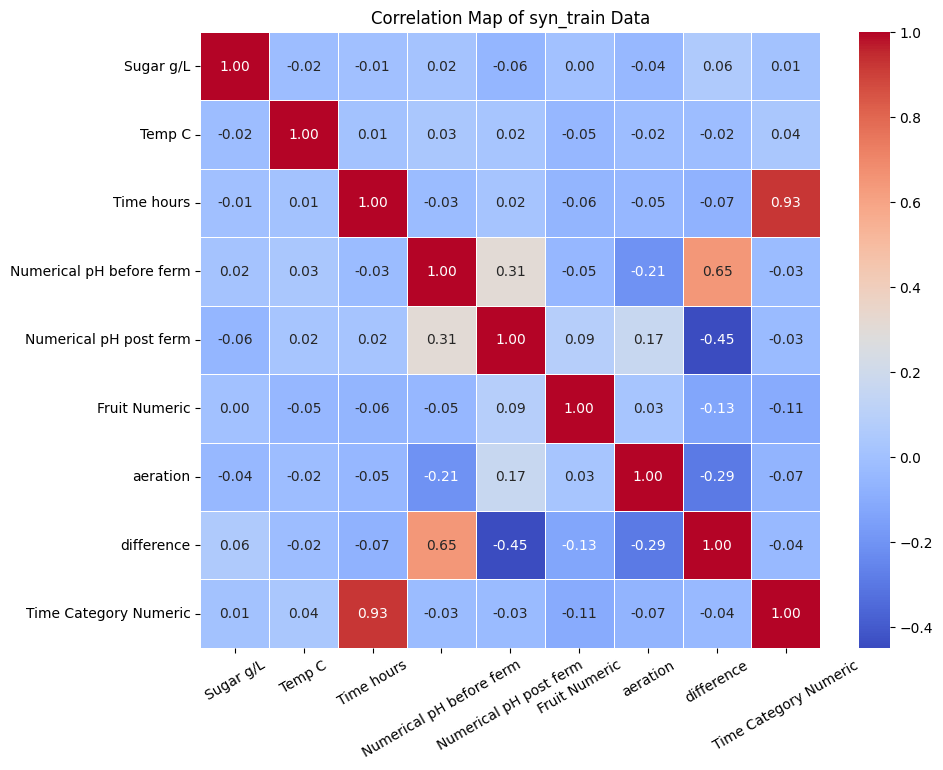

In [ ]:
# Filter out rows where 'Time hours' is 144
train_data = train_data[train_data['Time hours'] != 144]

# Calculate the correlation matrix
correlation_matrix = train_data.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Rotate the x-axis column names by 30 degrees
plt.xticks(rotation=30)

# Display the plot
plt.title('Correlation Map of syn_train Data')
plt.show()

In [ ]:
train_data[(train_data['Sugar g/L'] == 100) & (train_data['Numerical pH post ferm'] == 4.1)].value_counts()

Sugar g/L  Temp C  Time hours  Numerical pH before ferm  Numerical pH post ferm  Fruit Numeric  aeration  difference  Time Category Numeric
100.0      23.0    28          5.0                       4.1                     2              4.70      1.7         0                        1
           31.0    28          6.0                       4.1                     2              0.66      1.9         0                        1
           36.0    336         4.0                       4.1                     2              0.68      0.3         2                        1
           40.0    36          4.0                       4.1                     3              4.03      0.8         0                        1
Name: count, dtype: int64

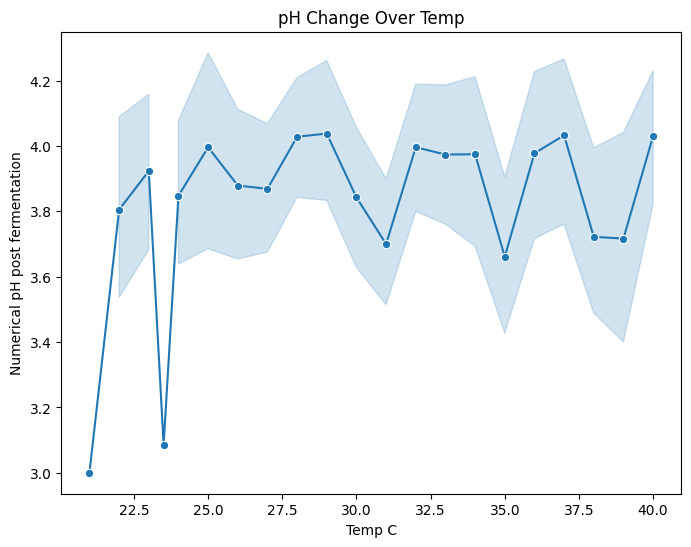

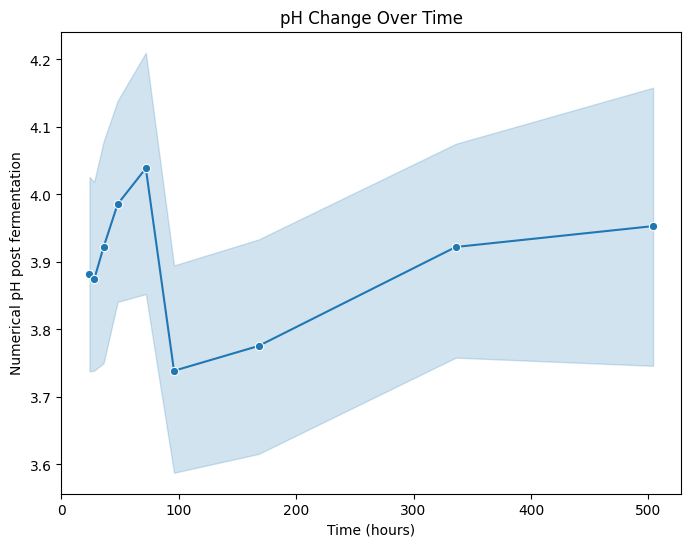

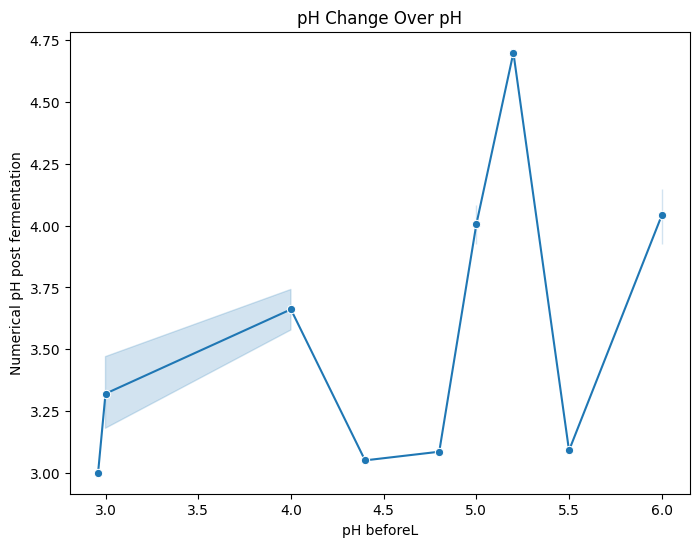

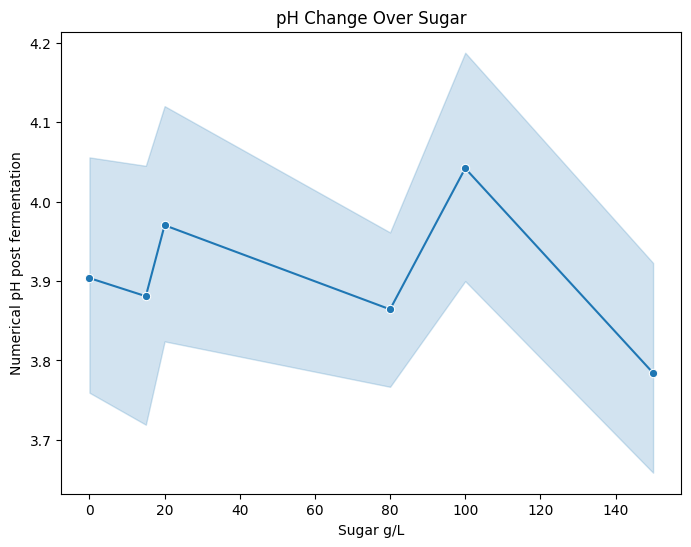

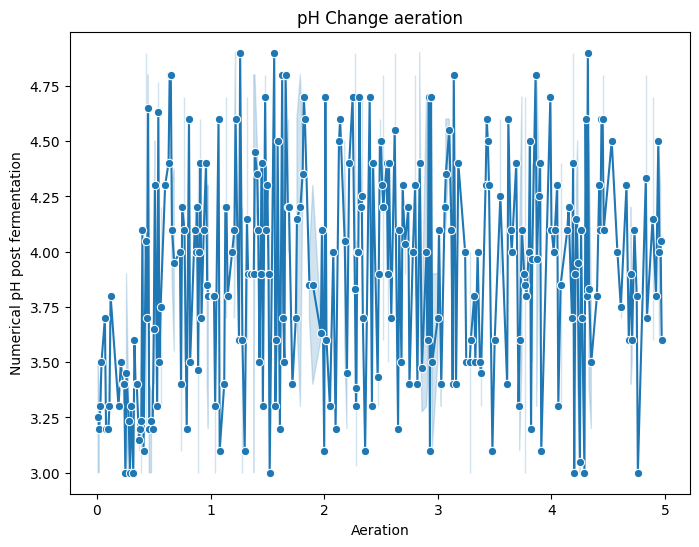

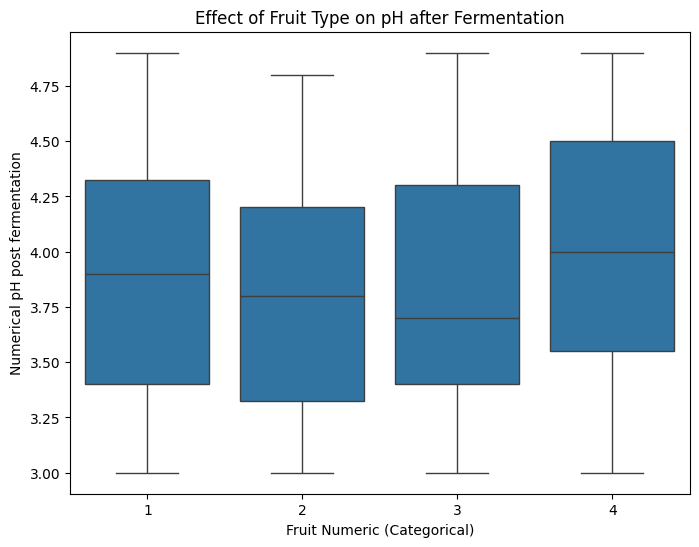

In [ ]:
# Combine features and target for visualization
df = train_data[['Fruit Numeric', 'Sugar g/L','Temp C', 'Time hours', 'Numerical pH before ferm', 'Numerical pH post ferm','aeration']]

#Line Plot (if time is an important factor)
plt.figure(figsize=(8, 6))
sns.lineplot(x=df['Temp C'], y=df['Numerical pH post ferm'], marker='o')
plt.title("pH Change Over Temp")
plt.xlabel("Temp C")
plt.ylabel("Numerical pH post fermentation")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=df['Time hours'], y=df['Numerical pH post ferm'], marker='o')
plt.title("pH Change Over Time")
plt.xlabel("Time (hours)")
plt.ylabel("Numerical pH post fermentation")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=df['Numerical pH before ferm'], y=df['Numerical pH post ferm'], marker='o')
plt.title("pH Change Over pH")
plt.xlabel("pH beforeL")
plt.ylabel("Numerical pH post fermentation")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=df['Sugar g/L'], y=df['Numerical pH post ferm'], marker='o')
plt.title("pH Change Over Sugar")
plt.xlabel("Sugar g/L")
plt.ylabel("Numerical pH post fermentation")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=df['aeration'], y=df['Numerical pH post ferm'], marker='o')
plt.title("pH Change aeration")
plt.xlabel("Aeration")
plt.ylabel("Numerical pH post fermentation")
plt.show()

# 3. Box Plot for 'Fruit Numeric' vs pH after fermentation
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Fruit Numeric'], y=df['Numerical pH post ferm'])
plt.title("Effect of Fruit Type on pH after Fermentation")
plt.xlabel("Fruit Numeric (Categorical)")
plt.ylabel("Numerical pH post fermentation")
plt.show()


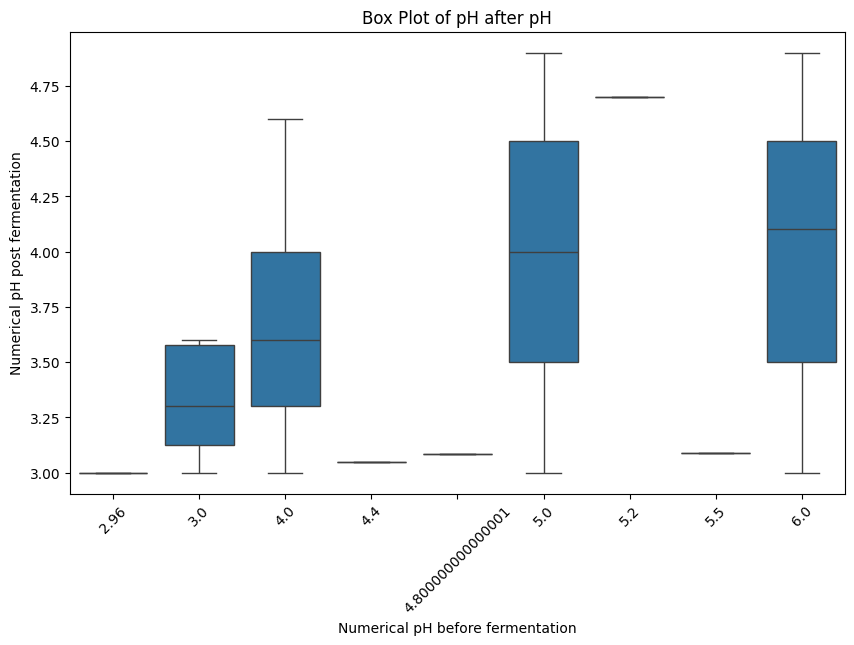

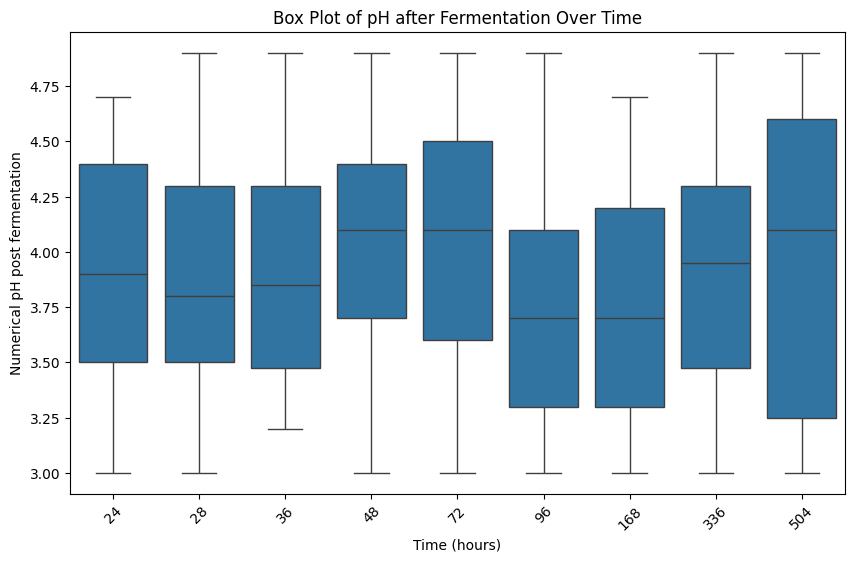

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data["Numerical pH before ferm"], y=train_data["Numerical pH post ferm"])
plt.title("Box Plot of pH after pH")
plt.xlabel("Numerical pH before fermentation")
plt.ylabel("Numerical pH post fermentation")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data["Time hours"], y=train_data["Numerical pH post ferm"])
plt.title("Box Plot of pH after Fermentation Over Time")
plt.xlabel("Time (hours)")
plt.ylabel("Numerical pH post fermentation")
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(fruit_mapping)

{'Blueberry': 1, 'Blackcurrant': 2, 'Lingonberry': 3, 'Cranberry': 4}


In [ ]:
train_data['Fruit Numeric'].value_counts()

,count
Fruit Numeric,
3,105
2,102
4,95
1,88


In [ ]:
train_data.isna().sum()

,0
Sugar g/L,0
Temp C,0
Time hours,0
Numerical pH before ferm,0
Numerical pH post ferm,0
Fruit Numeric,0
aeration,0
difference,5
Time Category Numeric,0


In [ ]:
train_data['Sugar g/L'].value_counts()

,count
Sugar g/L,
80.0,117
150.0,70
100.0,57
20.0,54
0.0,50
15.0,42


In [ ]:
# Features (X) and Target (y) for training
X_train = train_data[['Fruit Numeric', 'Temp C', 'Sugar g/L', 'Time hours', 'Numerical pH before ferm','aeration']]
y_train = train_data['Numerical pH post ferm']

# Features (X) and Target (y) for testing
X_test = test_data[['Fruit Numeric', 'Temp C', 'Sugar g/L', 'Time hours', 'Numerical pH before ferm','aeration']]
y_test = test_data['Numerical pH post ferm']

# Select numerical features to scale (exclude categorical)
numeric_features = ['Sugar g/L', 'Numerical pH before ferm', 'aeration']

# Initialize the scaler
scaler = StandardScaler()

# Make copies to avoid modifying the original data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Apply scaling only to numerical features
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Initialize the models
rfr = RandomForestRegressor()
etr = ExtraTreesRegressor()
abr = AdaBoostRegressor()
gbr = GradientBoostingRegressor()
lnr = LinearRegression()
xgb = XGBRegressor()

# List of models
models = [rfr, etr, abr, gbr, lnr, xgb]
names = ["Random Forest", "Extra Trees", "Ada Boost", "Gradient Boosting", "Linear Regression", "XGBoost"]

# Initialize lists to store results
r2s, mses = [], []

# Function to train and evaluate models
def training(model):
    model.fit(X_train_scaled, y_train)  # Train with scaled features
    pred = model.predict(X_test_scaled)  # Predict using scaled test data
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print("MSE: ", mse)
    print("R²: ", r2)
    return mse, r2

# Train each model and print the results
for model, name in zip(models, names):
    print("*" * 30)
    print(name)
    mse, r2 = training(model)
    print("\n")
    r2s.append(r2)
    mses.append(mse)

******************************
Random Forest
MSE:  0.19472289383838345
R²:  0.3644765072145124


******************************
Extra Trees
MSE:  0.2128429963636361
R²:  0.3053373345189918


******************************
Ada Boost
MSE:  0.21103484732845665
R²:  0.31123864980689875


******************************
Gradient Boosting
MSE:  0.1914240847194544
R²:  0.37524293869038416


******************************
Linear Regression
MSE:  0.2736482288763686
R²:  0.106885303612967


******************************
XGBoost
MSE:  0.2295257953330301
R²:  0.2508891365620163




In [ ]:
# Define a function to predict pH using AdaBoost
def predict_pH(model, feature_values, X_train):
    """
    Predicts the Numerical pH post fermentation using the trained AdaBoost model.

    Parameters:
    model: Trained AdaBoostRegressor model.
    feature_values: A dictionary containing feature names and their values.
    X_train: The DataFrame with training feature names (for column alignment).

    Returns:
    Predicted pH value.
    """
    # Ensure the input feature values match the columns in the training data
    feature_df = pd.DataFrame([feature_values], columns=X_train.columns)

    # Ensure the shape is correct before making a prediction
    print("Feature shape:", feature_df.shape)  # Debugging line

    # Make prediction
    predicted_pH = model.predict(feature_df)[0]

    return predicted_pH

# Example usage
example_features = {
    'Fruit Numeric': 1,
    'Sugar g/L': 15.0,
    'Time hours': 28,
    'Numerical pH before ferm': 6.2
}

# Check and ensure correct indexing for the test set
print("X_test first few rows:")
print(X_test.head())  # Check input features of test data

print("y_test first few rows:")
print(y_test.head())  # Check corresponding labels

# Ensure alignment by resetting indices (if needed)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Select a specific row for prediction (example for index 1)
index_to_predict = 4  # Example: second row of X_test
feature_row = X_test.iloc[index_to_predict]
actual_label = y_test.iloc[index_to_predict]  # Corresponding actual label
# Print the actual pH value
print(f"Actual pH post fermentation for row {index_to_predict}: {actual_label}")

# Assuming 'abr' is your trained AdaBoost model and 'X_train' is the training set
predicted_value = predict_pH(gbr, feature_row, X_train)

# Print the predicted value
print(f"Predicted pH after fermentation for row {index_to_predict}: {predicted_value}")


X_test first few rows:
   Fruit Numeric  Temp C  Sugar g/L  Time hours  Numerical pH before ferm  \
0              1    37.0       15.0          28                       6.2   
1              1    25.0      130.0          48                       4.0   
2              4    23.0       80.0         336                       5.0   
3              1    40.0      100.0         504                       6.0   
4              2    32.0       80.0          72                       6.0   

   aeration  
0  2.283548  
1  2.283548  
2  0.570000  
3  0.250000  
4  0.050000  
y_test first few rows:
0    3.08
1    3.50
2    4.50
3    3.10
4    3.20
Name: Numerical pH post ferm, dtype: float64
Actual pH post fermentation for row 4: 3.2
Feature shape: (1, 6)
Predicted pH after fermentation for row 4: 4.343564641663851


In [ ]:
# Predict pH values for the entire test set
y_pred_abr = gbr.predict(X_test)

# Create a DataFrame to compare actual vs. predicted values
comparison_df = pd.DataFrame({
    'Actual pH post ferm': y_test.values,
    'Predicted pH post ferm': y_pred_abr,
    'Fruit type': test_data['Fruit Numeric']
})

# Print the full comparison
print(comparison_df)

    Actual pH post ferm  Predicted pH post ferm  Fruit type
0                  3.08                4.089272           1
1                  3.50                4.267883           1
2                  4.50                4.352133           4
3                  3.10                4.503194           1
4                  3.20                4.343565           2
..                  ...                     ...         ...
94                 4.90                4.255681           3
95                 3.50                4.312954           4
96                 3.70                4.162813           3
97                 3.10                4.432708           1
98                 4.00                4.383781           3

[99 rows x 3 columns]


In [ ]:
print(fruit_mapping)

{'Blueberry': 1, 'Blackcurrant': 2, 'Lingonberry': 3, 'Cranberry': 4}


In [ ]:
# Assuming you have trained a model (e.g., Gradient Boosting)
model = gbr  # Replace with your best-performing model

# Get feature importances
importances = model.feature_importances_

# Get feature names (ensure X_train is a DataFrame)
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance (highest to lowest)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance_df)


                    Feature  Importance
5                  aeration    0.392500
4  Numerical pH before ferm    0.368584
1                    Temp C    0.089088
3                Time hours    0.057552
0             Fruit Numeric    0.047746
2                 Sugar g/L    0.044530


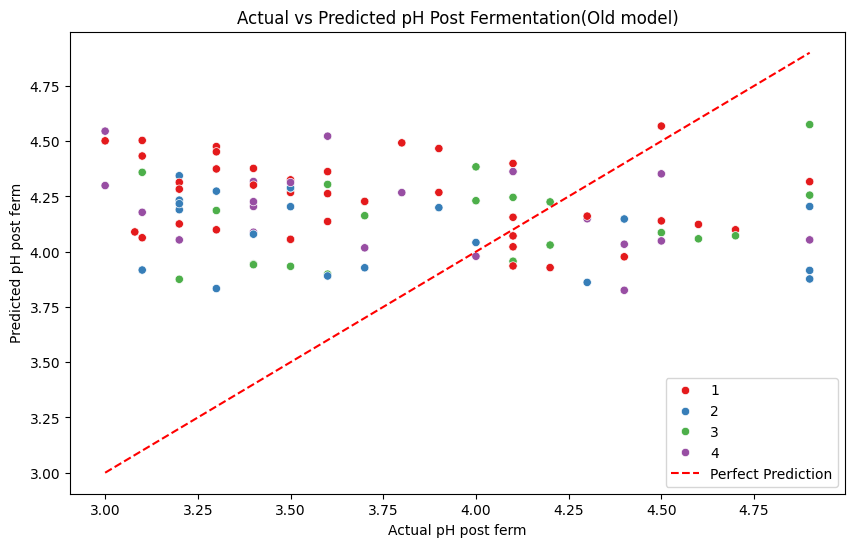

In [ ]:
# Plot actual vs. predicted pH post fermentation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df['Actual pH post ferm'], y=comparison_df['Predicted pH post ferm'], hue=comparison_df['Fruit type'], palette='Set1')

# Add line for perfect prediction (y = x)
plt.plot([min(comparison_df['Actual pH post ferm']), max(comparison_df['Actual pH post ferm'])],
         [min(comparison_df['Actual pH post ferm']), max(comparison_df['Actual pH post ferm'])],
         color='red', linestyle='--', label='Perfect Prediction')

# Add labels and title
plt.title('Actual vs Predicted pH Post Fermentation(Old model)')
plt.xlabel('Actual pH post ferm')
plt.ylabel('Predicted pH post ferm')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import joblib
model.random_state = None  # Optional: clear random state to avoid RNG issues
joblib.dump(gbr, "gradient_boost_compatible_2.pkl")


['gradient_boost_compatible_2.pkl']

In [ ]:
# Filter only lab_df rows from test_data
lab_test_data = lab_df.reset_index(drop=True)

# Separate features and labels from lab_test_data
X_lab_test = lab_test_data.drop(columns=['Numerical pH post ferm'])  # Adjust column name as needed
y_lab_test = lab_test_data['Numerical pH post ferm']

# Store matches
matching_rows = []

# Loop through each row in lab_test_data
for i in range(len(X_lab_test)):
    features = X_lab_test.iloc[i]
    actual = y_lab_test.iloc[i]
    predicted = predict_pH(gbr, features, X_train)
    diff = abs(predicted - actual)

    if diff < 0.8:
        row_result = lab_test_data.iloc[i].copy()
        row_result['Predicted pH'] = predicted
        row_result['Actual pH'] = actual
        row_result['Difference'] = diff
        matching_rows.append(row_result)

# Convert results to a DataFrame
matching_df = pd.DataFrame(matching_rows)

# Show matching predictions
print("Rows from lab_df with prediction difference < 0.5:")
print(matching_df)

Feature shape: (1, 6)
Feature shape: (1, 6)
Feature shape: (1, 6)
Feature shape: (1, 6)
Feature shape: (1, 6)
Feature shape: (1, 6)
Feature shape: (1, 6)
Feature shape: (1, 6)
Rows from lab_df with prediction difference < 0.5:
   Sugar g/L  Temp C  Time hours  Numerical pH before ferm  \
1      130.0    25.0        48.0                       4.0   
4      150.0    25.0       168.0                       5.2   

   Numerical pH post ferm  Fruit Numeric  aeration  Predicted pH  Actual pH  \
1                     3.5            1.0  2.283548      4.267883        3.5   
4                     4.7            3.0  2.283548      4.056965        4.7   

   Difference  
1    0.767883  
4    0.643035  


In [ ]:
!git clone https://github.com/zignut1035/Post-pH-prediction.git
%cd Post-pH-prediction


Cloning into 'Post-pH-prediction'...
/content/Post-pH-prediction/Post-pH-prediction


In [26]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [30]:
!ls /content/drive/MyDrive


 AD3BFE4E-523B-4372-8AE1-8DDE0647B71D.png	   TOR8.gdoc
'APPLICATION FORM (1).pdf'			   Untitled0.ipynb
'APPLICATION FORM.pdf'				   Untitled1.ipynb
 Artistic					   Untitled2.ipynb
'Colab Notebooks'				   Untitled3.ipynb
 Fortum_sopimusvahvistus_77_7764301_16068018.pdf   Untitled4.ipynb
'Getting started.pdf'				   Untitled5.ipynb
'image (1).jpg'					   Untitled6.ipynb
'image (2).jpg'					   Untitled7.ipynb
 image.jpg					   Untitled8.ipynb
 tensorflow					   Untitled9.ipynb
